# CSC413 Assignment 1: Word Embeddings

**Deadline**: February 5, 2021 by 10pm

**Submission**: Submit a PDF report containing your code, outputs,
and your written solutions.
You may export the completed notebook, but if you do so
**it is your responsibly to make sure that your code and answers do not get cut off**.

**Late Submission**: Please see the syllabus for the late submission criteria.

**Working with a partner**: You may work with a partner for this assignment.
If you decide to work with a partner, please create your group on Markus by
February 5, 10pm, even if you intend to use grace tokens. Markus does not allow
you to create groups past the deadline, even if you have grace tokens remaining.

Based on an assignment by George Dahl, Jing Yao Li, and Roger Grosse

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three. We will apply an idea called *weight sharing*
to go beyond multi-layer perceptrons with only fully-connected layers.

We will also solve this problem problem twice: once in numpy, and once
using PyTorch. When using numpy, you'll implement the backpropagation
computation manually.

The prediction task is not very interesting on its own, but in learning to predict
subsequent words given the previous three, our neural networks will learn
about how to *represent* words. In the last part of the assignment, we'll explore
the *vector representations* of words that our model produces, and analyze these
representations.

You may modify the starter code, including changing the signatures of helper 
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

In [38]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like.
Download the file `raw_sentences.txt` from Quercus.

If you're using Google Colab, upload the file to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [40]:
file_path = '/content/gdrive/My Drive/CSC413/raw_sentences.txt' # TODO - UPDATE ME!

You might find it helpful to know that you can run shell commands (like `ls`) by
using `!` in Google Colab, like this:

In [ ]:
!ls /content/gdrive/My\ Drive/
!mkdir /content/gdrive/My\ Drive/CSC413

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [41]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [42]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use 10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [43]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 2 pts

Display 10 sentences in the training set.
Explain how punctuations are treated in our word representation, and how words
with apostrophes are represented.

(Note that for questions like this, you'll need to supply both your code **and**
the output of your code to earn full credit.)

In [44]:
for i in range(10):
  print(train[i])
#Punctuations are treated as another word. However apostrophes are treated as spaces, 
#therefore words like "didn't" is treated as "did" and "nt" and each of them are treated as words seperately.

['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.']
['on', 'what', 'can', 'i', 'do', '?']
['now', 'where', 'does', 'it', 'go', '?']
['what', 'did', 'the', 'court', 'do', '?']
['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.']
['that', 'was', 'the', 'only', 'way', '.']
['this', 'team', 'will', 'be', 'back', '.']
['so', 'that', 'is', 'what', 'i', 'do', '.']
['we', 'have', 'a', 'right', 'to', 'know', '.']
['now', 'they', 'are', 'three', '.']


### Part (b) -- 2 pts

What are the 10 most common words in the vocabulary? How often does each of these
words appear in the training sentences? Express the second quantity a percentage
(i.e. number of occurrences of the  word / total number of words in the training set).

These are good quantities to compute, because one of the first things that most
machine learning model will learn is to predict the **most common** class.
Getting a sense of the distribution of our data will help you understand our
model's behaviour.

You might find Python's `collections.Counter` class helpful.

In [45]:
# Your code goes here
from collections import Counter
c = Counter()
for i in range(len(sentences)):
  c += Counter(sentences[i])

m_common = c.most_common(10)
print("The 10 most common words in the vocabulary are: ")
for i in range(len(m_common)):
  print(str(i+1) + ": " + m_common[i][0])

print("The percentage of the 10 most common words in the training set are: ")
c2 = Counter()
for i in range(len(train)):
  c2 += Counter(train[i])

for i in range(len(c2.most_common(10))):
  print((c2[m_common[i][0]]/len(train)) * 100)



The 10 most common words in the vocabulary are: 
1: .
2: it
3: ,
4: i
5: do
6: to
7: nt
8: ?
9: the
10: that
The percentage of the 10 most common words in the training set are: 
83.327285451388
29.96034317410124
25.319457764184445
22.91801664031518
20.970166662346752
20.074648142868252
16.85933490578264
16.69345014385319
16.307249682486198
16.245042896762655


### Part (c) -- 4 pts

Complete the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other. You can use the constants `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [46]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """

    for i in range(len(sents)):
      for j in range(len(sents[i])):
        sents[i][j] = vocab_stoi[sents[i][j]]

    return sents

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    four_gram = []
    for i in range(len(seqs)):
      if(len(seqs[i]) > 3):
        for j in range(len(seqs[i]) - 3):
            four_gram.append(seqs[i][j:j+4])

    return four_gram

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

## Question 2. MLP Math

Suppose we were to use a 2-layer multilayer perceptron to solve this prediction
problem. Our model will look like this:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model1.png" />

\begin{align*}
\bf{x} &= \text{concatenation of the one-hot vector for words 1, 2 and 3} \\
\bf{m} &= \bf{W^{(1)}} \bf{x} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
\end{align*}

### Part (a) -- 2 pts

What is the shape of the input vector $\bf{x}$?
What is the shape of the output vector $\bf{y}$?
Let $k$ represent the size of the hidden layer. What are the
dimension of $W^{(1)}$ and $W^{(2)}$?

In [ ]:
# The shape of x is 750 x 1. The shape of y is 250 x 1. The dimensions of W(1) is 750 x k and dimensions of W(2) is k x 250

### Part (b) -- 2 pts

Draw a computation graph for $\bf{y}$. Your graph should include
the quantities $\bf{W^{(1)}}$, $\bf{W^{(2)}}$, $\bf{b^{(1)}}$, $\bf{b^{(2)}}$,
$\bf{x}$, $\bf{m}$, $\bf{h}$, $\bf{z}$ and $\bf{y}$.

![picture](https://drive.google.com/uc?export=view&id=1yvp31lsarriJEirbYxc96tEV0bSEONuf)

### Part (c) -- 3 pts

Derive the gradient descent update rule for ${\bf W}^{(2)}$.
You should begin by deriving the update rule for $W^{(2)}_{ij}$,
and then vectorize your answer. Assume that we will use the softmax
activation and cross-entropy loss.

Note: if you use the derivative of the softamx activation and
the cross-entropy loss, you **must** derive them.

![picture](https://drive.google.com/uc?export=view&id=1jTPkkoINH7jRqEYo4YKgBi_uzZffmwPp)

![picture](https://drive.google.com/uc?export=view&id=1LwPbobV9-ef4UX7DRpAm_kSmwDSxB2Lz)

### Part (d) -- 4 pts

What would be the update rule for $W^{(2)}_{ij}$, if we use the square loss
$\mathcal{L}_{SE}(\bf{y}, \bf{t}) = \frac{1}{2}(\bf{y} - \bf{t})^2$ ?

Show that we will not get good gradient signal
to update $W^{(2)}_{ij}$ if we use this square loss.

![picture](https://drive.google.com/uc?export=view&id=1HLg3yIIGV-GCjf7U7xSmvAg9BPFEXru6)

In [ ]:
# If we choose to use squared loss, the value of our error will be significantly large which will cause
# our gradient to become very small. This will have bad effects on the training.
# Therefore squared loss will not get good gradient signal.

### Part (e) -- 4 pts

In this question, we'll show a similar issue with using 
the sigmoid activation. Let's assume we have a deep neural network
as follows:

\begin{align*}
h_1 &= \sigma(w_1 x + b_1) \\
h_2 &= \sigma(w_2 h_1 + b_2) \\
\dots
\end{align*}

where, for simplicity, $x$, $w_1$, $b_1$, $h_1$, $w_2$, $b_2$, $h_2$, etc., are all scalars. Show that

\begin{align*}
|\frac{\partial h_1}{\partial x}| \le \frac{1}{4} |w_1|
\end{align*}

In order to do so, you will need to first
show that $\sigma'(z) = \sigma(z) (1 - \sigma(z))$ (worth 1 point). 
Include a plot (or sketch) of the function $\sigma'(z)$ (worth 1 point).

![picture](https://drive.google.com/uc?export=view&id=1BACvjwp0Q6bmwrdbA-pwoNMD4boFuNh7)

![picture](https://drive.google.com/uc?export=view&id=1ksPrQbN4zk1YlbAYdrD87KNbsQOOvl5k)

### Part (f) -- 2 pts

Continue from the previous question, show that for a deeper neural network.

\begin{align*}
|\frac{\partial h_N}{\partial x}| \le \frac{1}{4^N} |w_1| |w_2| \cdots |w_N|
\end{align*}

What would be a problem with this result?

In [ ]:
# The problem is that if the value of N is very large, the derivative will be too small.
# This will cause an issue called vanishing gradients and is will cause poor learning for
# deep neural networks.

### Part (g) -- 1 pts

Would we have the same issue as in part(f) we we replaced the sigmoid activation
with ReLU activations? Why or why not?

In [ ]:
# No the issue will not occur because the derivative of the ReLU will never become small therefore
# the vanishing gradient will never occur.

## Question 3. Weight Sharing - Math

From this point onward, we will change our architecture to introduce weight sharing.
In particular, the input $\bf{x}$ consists of three one-hot vectors concatenated
together. We can think of $\bf{h}$ as a representation of those three words
(all together). However, $\bf{W^{(1)}}$ needs to learn about the first word
separately from the second and third word, when some of the information could
be shared. Consider the following architecture:

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p2_model2.png" />

Here, we add an extra *embedding* layer to the neural network, where we compute
the representation of **each** word before concatenating them together! We use
the same weight $\bf{W}^{(word)}$ for each of the three words:

\begin{align*}
\bf{x_a} &= \textrm{the one-hot vector for word 1} \\
\bf{x_b} &= \textrm{the one-hot vector for word 2} \\
\bf{x_c} &= \textrm{the one-hot vector for word 3} \\
\bf{v_a} &= \bf{W}^{(word)} \bf{x_a} \\
\bf{v_b} &= \bf{W}^{(word)} \bf{x_b} \\
\bf{v_c} &= \bf{W}^{(word)} \bf{x_c} \\
\bf{v} &= \textrm{concatenation of } \bf{v_a}, \bf{v_b}, \bf{v_c} \\
\bf{m} &= \bf{W^{(1)}} \bf{v} + \bf{b^{(1)}} \\
\bf{h} &= \textrm{ReLU}(\bf{m}) \\
\bf{z} &= \bf{W^{(2)}} \bf{h} + \bf{b^{(2)}} \\
\bf{y} &= \textrm{softmax}(\bf{z}) \\
\end{align*}

Note that there are no biases in the embedding layer.

### Part (a) -- 4 pts

Draw a computation graph for $\bf{y}$. Your graph should include
the quantities $\bf{W}^{(word)}$, $\bf{W^{(1)}}$, $\bf{W^{(2)}}$,
$\bf{b^{(1)}}$, $\bf{b^{(2)}}$,
$\bf{x_a}$,$\bf{x_b}$, $\bf{x_c}$,
$\bf{v_a}$,$\bf{v_b}$, $\bf{v_c}$, $\bf{v}$,
$\bf{m}$, $\bf{h}$, $\bf{z}$ and $\bf{y}$.

![picture](https://drive.google.com/uc?export=view&id=1cFXMVsGCsOWlXRlxDqhAuLIHL-VD7nc3)

### Part (b) -- 2 pts

Using the computation graph from part (e), use the chain rule to
write the quantity $\frac{\partial{\bf y}}{\partial{\bf W}^{(word)}}$
in terms of derivatives along the edges in the computation graph
(e.g. $\frac{\partial \bf{y}}{\partial {\bf z}} \frac{\partial \bf{z}}{\partial {\bf \cdot}} \dots$)

You don't need to compute the actual derivatives along the edges
for this question.  However, you will need to in Q4(a).

![picture](https://drive.google.com/uc?export=view&id=12_1Kn3tqfcrHDl8Ui6VP7pa894S6HoAW)

## Question 4. NumPy

In this question, we will implement the model from Question 3
using NumPy.  Start by reviewing these helper functions,
which are given to you:

In [47]:
def make_onehot(indicies, total=250):
    """
    Convert indicies into one-hot vectors by
        1. Creating an identity matrix of shape [total, total]
        2. Indexing the appropriate columns of that identity matrix
    """
    I = np.eye(total)
    return I[indicies]

def softmax(x):
    """
    Compute the softmax of vector x, or row-wise for a matrix x.
    We subtract x.max(axis=0) from each row for numerical stability.
    """
    x = x.T
    exps = np.exp(x - x.max(axis=0))
    probs = exps / np.sum(exps, axis=0)
    return probs.T

def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xs, ts) where:
     - `xs` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `ts` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xs = data[range_min:range_max, :3]
    xs = make_onehot(xs)
    ts = data[range_min:range_max, 3]
    if onehot:
        ts = make_onehot(ts).reshape(-1, 250)
    return xs, ts

def estimate_accuracy(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        z = model(xs)
        pred = np.argmax(z, axis=1)
        correct += np.sum(ts == pred)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

### Part (a) -- 8 point

Your first task is to implement the model from Question 3 in NumPy.
We will represent the model as a Python class. We set up the 
class methods and APIs to be similar to that of PyTorch, so that you
have some intuition about what PyTorch is doing under the hood.
Here's what you need to do:

1. in the `__init__` method, initialize the weights and biases to have the correct shapes. You may want to look back at your answers in the previous question. (0 points)
2. complete the `forward` method to compute the predictions given a **batch** of inputs. This function will also store the intermediate values obtained in the computation; we will need these values for gradient descent. (3 points)
3. complete the `backward` method to compute the gradients of the loss with respect to the weights and biases. (4 points)
4. complete the `update` method that uses the stored gradients to update the weights and biases. (1 point)

In [48]:
class NumpyWordEmbModel(object):
    def __init__(self, vocab_size=250, emb_size=100, num_hidden=100):
        """
        Initialize the weights and biases to zero. Update this method
        so that weights and baises have the correct shape.
        """
        TODO = 0
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.num_hidden = num_hidden
        self.emb_weights = np.zeros([emb_size, vocab_size]) # W^{(word)}
        self.weights1 = np.zeros([num_hidden, 3 * emb_size])    # W^{(1)}
        self.bias1 = np.zeros([num_hidden])             # b^{(1)}
        self.weights2 = np.zeros([vocab_size, num_hidden])    # W^{(2)}
        self.bias2 = np.zeros([vocab_size])             # b^{(2)}
        self.cleanup()

    def initializeParams(self):
        """
        Randomly initialize the weights and biases of this two-layer MLP.
        The randomization is necessary so that each weight is updated to
        a different value.

        You do not need to change this method.
        """
        self.emb_weights = np.random.normal(0, 2/self.emb_size, self.emb_weights.shape)
        self.weights1 = np.random.normal(0, 2/self.emb_size, self.weights1.shape)
        self.bias1 = np.random.normal(0, 2/self.emb_size, self.bias1.shape)
        self.weights2 = np.random.normal(0, 2/self.num_hidden, self.weights2.shape)
        self.bias2 = np.random.normal(0, 2/self.num_hidden, self.bias2.shape)

    def forward(self, inputs):
        """
        Compute the forward pass prediction for inputs.

        Note that for vectorization, `inputs` will be a rank-3 numpy array
        with shape [N, 3, vocab_size], where N is the batch size.
        The returned value will contain the predictions for the N
        data points in the batch, so the return value shape should be
        [N, something].

        You should refer to the mathematical expressions we provided in Q3
        when completing this method. However, because we are computing
        forward pass for a batch of data at a time, you may need to rearrange
        some computation (e.g. some matrix-vector multiplication will become
        matrix-matrix multiplications, and you'll need to be careful about
        arranging the dimensions of your matrices.)

        For numerical stability reasons, we will return the **logit z**
        instead of the **probability y**. The loss function assumes that 
        we return the logits from this function.

        After writing this function, you might want to check that your code
        runs before continuing, e.g. try

            xs, ts = get_batch(train4grams, 0, 8, onehot=True)
            m = NumpyWordEmbModel()
            m.forward(xs)
        """
        self.N = inputs.shape[0]
        self.xa = inputs[:, 0, :] # todo
        self.xb = inputs[:, 1, :] # todo
        self.xc = inputs[:, 2, :] # todo
        self.va = np.matmul(self.xa, self.emb_weights.T) # todo
        self.vb = np.matmul(self.xb, self.emb_weights.T) # todo
        self.vc = np.matmul(self.xc, self.emb_weights.T) # todo
        self.v = np.concatenate((self.va,self.vb,self.vc), axis=1) # todo
        self.m = np.matmul(self.v, self.weights1.T) + self.bias1 # todo
        self.h = np.maximum(np.zeros_like(self.m),self.m) # todo
        self.z = np.matmul(self.h, self.weights2.T) + self.bias2 # todo
        self.y = softmax(self.z)
        return self.y

    def __call__(self, inputs):
        """
        This function is here so that if you call the object like a function,
        the `backward` method will get called. For example, if we have
            m = NumpyWordEmbModel()
        Calling `m(foo)` is equivalent to calling `m.forward(foo)`.

        You do not need to change this method.
        """
        return self.forward(inputs)

    def backward(self, ts):
        """
        Compute the backward pass, given the ground-truth, one-hot targets.
        Note that `ts` needs to be a numpy array with shape [N, vocab_size].
        Complete this method. You might want to refer to your answers to Q2
        and Q3. But be careful: we are computing the backward pass for an
        entire batch of data at a time! Carefully track the dimensions of your
        quantities!

        You may assume that the forward() method has already been called, so
        you can access values like self.N, self.y, etc..

        This function needs to be called before calling the update() method.
        """
        z_bar = (self.y - ts) / self.N
        self.w2_bar = np.dot(z_bar.T, self.h) # todo, compute gradient for W^{(2)}
        self.b2_bar = np.dot(z_bar.T, np.ones(self.N)) # todo, compute gradient for b^{(2)}
        h_bar = np.matmul(z_bar, self.weights2) # todo
        m_bar = h_bar * (self.m > 0) # todo
        self.w1_bar = np.dot(m_bar.T, self.v) # todo
        self.b1_bar = np.dot(m_bar.T, np.ones(self.N)) # todo
        v_bar = np.matmul(m_bar, self.weights1)
        va_bar = np.dot(v_bar.T[:100, :], self.xa)
        vb_bar = np.dot(v_bar.T[100:200, :], self.xb)
        vc_bar = np.dot(v_bar.T[200:, :], self.xc)
        self.emb_bar = va_bar + vb_bar + vc_bar # todo, compute gradient for W^{(word)}

    def update(self, alpha):
        """
        Compute the gradient descent update for the parameters.
        Complete this method. Use `alpha` as the learning rate.

        You can assume that the forward() and backward() methods have already
        been called, so you can access values like self.w1_bar.
        """
        self.weights1 = self.weights1 - alpha * self.w1_bar
        self.bias1 = self.bias1 - alpha * self.b1_bar
        self.weights2 = self.weights2 - alpha * self.w2_bar
        self.bias2 = self.bias2 - alpha * self.b2_bar
        self.emb_weights = self.emb_weights - alpha * self.emb_bar

    def cleanup(self):
        """
        Erase the values of the variables that we use in our computation.
       
        You do not need to change this method.
        """
        self.N = None
        self.xa = None
        self.xb = None
        self.xc = None
        self.va = None
        self.vb = None
        self.vc = None
        self.v = None
        self.m = None
        self.h = None
        self.z = None
        self.y = None
        self.z_bar = None
        self.w2_bar = None
        self.b2_bar = None
        self.w1_bar = None
        self.b1_bar = None
        self.emb_bar = None

### Part (b) -- 2 points

Complete the `run_gradient_descent` function. Train your numpy model
to obtain a training accuracy of at least 25%. You do not need to train
this model to convergence, but you do need to clearly show
that your model reached at least 25% training accuracy.

In [37]:
def run_gradient_descent(model,
                         train_data=train4grams,
                         validation_data=valid4grams,
                         batch_size=100,
                         learning_rate=0.1,
                         max_iters=5000):
    """
    Use gradient descent to train the numpy model on the dataset train4grams.
    """
    n = 0
    while n < max_iters:
        # shuffle the training data, and break early if we don't have
        # enough data to remaining in the batch
        np.random.shuffle(train_data)
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=True)

            # erase any accumulated gradients
            model.cleanup()

            # forward pass: compute prediction
            y = model.forward(xs)

            # TODO: add your code here

            # backward pass: compute error 
            model.backward(ts)
            model.update(learning_rate)
            model.cleanup()

            # increment the iteration count
            n += 1

            # compute and plot the *validation* loss and accuracy
            if (n % 100 == 0):
                train_cost = -np.sum(ts * np.log(y)) / batch_size
                train_acc = estimate_accuracy(model, train_data)
                val_acc = estimate_accuracy(model, validation_data)
                model.cleanup()
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

        if n >= max_iters:
            return


numpy_model= NumpyWordEmbModel()
numpy_model.initializeParams()
run_gradient_descent(numpy_model, max_iters=5000)

Iter 100. [Val Acc 17%] [Train Acc 17%, Loss 5.016580]
Iter 200. [Val Acc 17%] [Train Acc 17%, Loss 4.794132]
Iter 300. [Val Acc 17%] [Train Acc 17%, Loss 4.802343]
Iter 400. [Val Acc 17%] [Train Acc 17%, Loss 4.648571]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.125644]
Iter 600. [Val Acc 17%] [Train Acc 17%, Loss 4.134703]
Iter 700. [Val Acc 17%] [Train Acc 17%, Loss 4.114157]
Iter 800. [Val Acc 17%] [Train Acc 17%, Loss 4.216607]
Iter 900. [Val Acc 17%] [Train Acc 17%, Loss 4.559055]
Iter 1000. [Val Acc 17%] [Train Acc 17%, Loss 4.395618]
Iter 1100. [Val Acc 17%] [Train Acc 17%, Loss 4.360966]
Iter 1200. [Val Acc 17%] [Train Acc 17%, Loss 4.506414]
Iter 1300. [Val Acc 17%] [Train Acc 17%, Loss 4.397461]
Iter 1400. [Val Acc 17%] [Train Acc 17%, Loss 4.231537]
Iter 1500. [Val Acc 17%] [Train Acc 17%, Loss 4.234883]
Iter 1600. [Val Acc 17%] [Train Acc 17%, Loss 4.286784]
Iter 1700. [Val Acc 17%] [Train Acc 17%, Loss 4.185975]
Iter 1800. [Val Acc 17%] [Train Acc 17%, Loss 4.271078]
I

### Part (c) -- 2 pts

If we do not call `numpy_model.initializeParams()`, your model weights will
not change. Clearly explain (mathematically) why this is the case.

In [ ]:
# Your answer goes here
# The gradient will be 0 which is caused by the saddle point when we take the weights with respect to the loss function.
# When back propagation happens, the weights will not get updated properly and remain the same every iteration. Mathematically
# we can show that w1 = w1 - (alpha * 0) = w1 - 0 = w1 because the gradient is equal to 0.

### Part (d) -- 2 pts

The `estimate_accuracy` function takes the continuous predictions `z`
and turns it into a discrete prediction `pred`. Show that for a given
data point, `pred` is equal to 1 only if the predictive probability `y`
is at least 0.5.

CORRECTION FEB 1ST:
The `estimate_accuracy` function takes the continuous predictions `z`
and turns it into a discrete prediction `pred`. Show (mathematically) that for a
given data point, the maximum column of `z` is the same as the maximum
column of `softmax(z)`.

![picture](https://drive.google.com/uc?export=view&id=1DRsFV6kBw8weud0rTP0zTA304EwkZ8MQ)

## Question 5. PyTorch

Now, we will build the same model in PyTorch.

### Part (a) -- 2 pts

Since PyTorch uses
automatic differentiation, we only need to write the *forward pass* of our
model. Complete the `__init__` and `forward` methods below.

Hint: You might want to look up the `reshape` method in PyTorch.

In [ ]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        TODO = 0
        self.word_emb_layer = nn.Linear(vocab_size,      # num input W^(word)
                                        emb_size,      # num output W^(word)
                                        bias=False)
        self.fc_layer1 = nn.Linear(3 * emb_size, # num input W^(1)
                                   num_hidden) # num output W^(1)
        self.fc_layer2 = nn.Linear(num_hidden, # num input W^(2)
                                   vocab_size) # num output W^(2)
        self.num_hidden = num_hidden
        self.emb_size = emb_size

    def forward(self, inp):
        vs = self.word_emb_layer(inp)
        v = torch.reshape(vs, (-1, self.num_hidden)) # TODO: what do you need to do here?
        m = self.fc_layer1(v)
        h = torch.relu(m)
        z = self.fc_layer2(h) # TODO: what do you need to do here?
        return z

### Part (b) -- 2 pts

The function `run_pytorch_gradient_descent` is given to you. It is similar
to the code that you wrote fro the PyTorch model, with a few differences:

1. We will use a slightly fancier optimizer called **Adam**. For this optimizer,
   a smaller learning rate usually works better, so the default learning
   rate is set to 0.001.
2. Since we get weight decay for free, you are welcome to use weight decay.


Use this function and train your PyTorch model to obtain a training
accuracy of at least 37%.  Plot the learning curve using the `plot_learning_curve`
function provided to you, and include your plot in your PDF submission.

In [ ]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        z = model(torch.Tensor(xs))
        z = z.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(z, axis=1)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/CSC413/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder CSC413, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/CSC413/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/CSC413/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xs, ts = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs)
            ts = torch.Tensor(ts).long()

            zs = model(xs)
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.517438]
Iter 500. [Val Acc 28%] [Train Acc 29%, Loss 3.163873]
Iter 1000. [Val Acc 30%] [Train Acc 31%, Loss 2.911472]
Iter 1500. [Val Acc 32%] [Train Acc 33%, Loss 3.038274]
Iter 2000. [Val Acc 33%] [Train Acc 33%, Loss 2.798192]
Iter 2500. [Val Acc 33%] [Train Acc 34%, Loss 2.594519]
Iter 3000. [Val Acc 34%] [Train Acc 34%, Loss 2.846265]
Iter 3500. [Val Acc 34%] [Train Acc 35%, Loss 2.886271]
Iter 4000. [Val Acc 34%] [Train Acc 36%, Loss 2.519231]
Iter 4500. [Val Acc 35%] [Train Acc 37%, Loss 2.515276]
Iter 5000. [Val Acc 35%] [Train Acc 36%, Loss 2.662256]
Iter 5500. [Val Acc 36%] [Train Acc 36%, Loss 2.687818]
Iter 6000. [Val Acc 36%] [Train Acc 36%, Loss 2.767042]
Iter 6500. [Val Acc 36%] [Train Acc 37%, Loss 2.535760]
Iter 7000. [Val Acc 36%] [Train Acc 37%, Loss 2.384735]
Iter 7500. [Val Acc 36%] [Train Acc 37%, Loss 2.608358]
Iter 8000. [Val Acc 36%] [Train Acc 38%, Loss 2.587498]
Iter 8500. [Val Acc 36%] [Train Acc 38%, Loss 2.494058

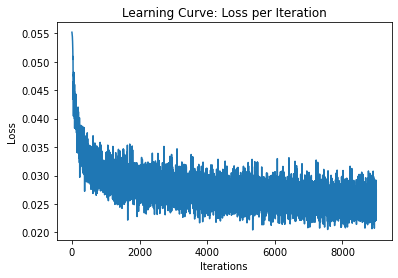

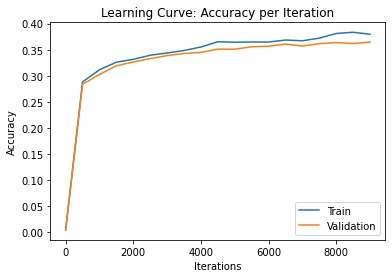

In [ ]:
pytorch_model = PyTorchWordEmb()
learning_curve_info = run_pytorch_gradient_descent(pytorch_model, max_iters=9000)

# you might want to save the `learning_curve_info` somewhere, so that you can plot
# the learning curve prior to exporting your PDF file

plot_learning_curve(*learning_curve_info)

### Part (c) -- 3 points

Write a function `make_prediction` that takes as parameters
a PyTorchWordEmb model and sentence (a list of words), and produces
a prediction for the next word in the sentence.

Start by thinking about what you need to do, step by step, taking
care of the difference between a numpy array and a PyTorch Tensor.

In [ ]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PyTorchWordEmb. You might find the function torch.argmax helpful.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_model, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos

    s = []
    for word in sentence:
      s.append(vocab_stoi[word])
      
    xs = make_onehot(s)
    y = model(torch.Tensor(xs))
    y = y.detach().numpy()
    pred = np.argmax(y, axis=1)
    wordpred = vocab_itos[pred[0]]
    return wordpred

### Part (d) -- 4 points

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense? (If all of your predictions are the same,
train your model for more iterations, or change the hyper parameters in your
model. You may need to do this even if your training accuracy is >=37%)

One concern you might have is that our model may be "memorizing" information
from the training set.  Check if each of 3-grams (the 3 words appearing next
to each other) appear in the training set. If so, what word occurs immediately
following those three words?

In [ ]:
sent = [["you", "are", "a"],["few", "companies", "show"],["there", "are", "no"],["yesterday", "i", "was"],["the", "game", "had"],["yesterday", "the", "federal"]]

for s in sent:
  predictedword = make_prediction_torch(pytorch_model, s)
  print("Sentence with predicted next word: " + str(s) + " has prediceted next word: " + predictedword)

Sentence with predicted next word: ['you', 'are', 'a'] has prediceted next word: good
Sentence with predicted next word: ['few', 'companies', 'show'] has prediceted next word: up
Sentence with predicted next word: ['there', 'are', 'no'] has prediceted next word: other
Sentence with predicted next word: ['yesterday', 'i', 'was'] has prediceted next word: nt
Sentence with predicted next word: ['the', 'game', 'had'] has prediceted next word: to
Sentence with predicted next word: ['yesterday', 'the', 'federal'] has prediceted next word: government


### Part (3) -- 1 points

Report the test accuracy of your model. The test accuracy is the percentage
of correct predictions across your test set.

In [ ]:
estimate_accuracy_torch(pytorch_model, test4grams)

0.3658073270013569

## Question 6. Visualizing Word Embeddings

While training the `PyTorchWordEmb`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings.

### Part (a) -- 1 pts

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
word_emb_weights = list(pytorch_model.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T

# The multiplication of the one hot vector of a word by word_emb contains a vector
# of that word. The weights that are shown in the result are the weights that are
# multiplied by the one_hot vector.

### Part (b) -- 1 pts

Once interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the cosine similarity of
every pair of words in our vocabulary.

In [ ]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.36301517
0.09170631


Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

In [ ]:
def closefive(word):
  s = np.argsort(similarities[vocab_stoi[word]])
  cl5 = s[-6:-1]
  cl5_list = []
  for i in cl5:
    cl5_list.append(vocab_itos[i])

  return cl5_list

words = ['four', 'go', 'what', 'should', 'school', 'your', 'yesterday', 'not']
for word in words:
  print(word + ": " + str(closefive(word)))


four: ['few', 'several', 'two', 'five', 'three']
go: ['get', 'day', 'going', 'back', 'come']
what: ['where', 'dr.', 'how', 'when', 'who']
should: ['will', 'might', 'can', 'would', 'could']
school: ['public', 'market', 'company', 'him', 'music']
your: ['its', 'our', 'his', 'my', 'their']
yesterday: ['night', 'ago', 'though', 'season', 'today']
not: ['even', 'also', 'should', 'never', 'nt']


### Part (c) -- 2 pts

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment,
but we may cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.
Look at the plot and find two clusters of related words.
What do the words in each cluster have in common?

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file for your TA to see.

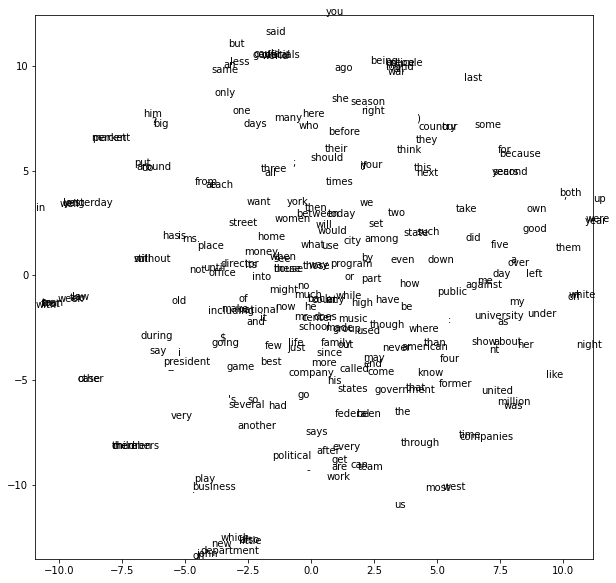

In [ ]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
    plt.text(Y[i, 0], Y[i, 1], w)
plt.show()

## Question 7. Work Allocation -- 2 pts

This question is to make sure that if you are working with a partner, that
you and your partner contributed equally to the assignment.

Please have each team member write down the times that you worked on the
assignment, and your contribution to the assignment.

In [ ]:
# Wafiqah and David read the assignment on our own time and discussed it on 
# Jan 22nd, 3pm-5pm. Wafiqah worked on the assignment Jan 22nd, 7pm-10pm Jan 23rd, 1pm - 4pm
# David worked on the assignment Jan 23rd, 11am - 5pm, Jan 24th, 3pm - 6pm.
# We had a meeting on Jan 25th, Jan 28th, Jan 31st, Feb 2nd, Feb 4th, and Feb 5th
# all around 6pm - 11pm.

# Wafiqah worked on Q1 and David reviewed the code.
# David worked out the math for Q2 explained it to Wafiqah. Wafiqah drew the computation 
# graph and derivation for Q3. We worked on Q4 and Q5 together while screensharing. 
# Wafiqah completed the functions and explanation for Q6 and David reviewed them. 
